<center><h3 style='color:red'>Keras | Transfer Learning (CAT vs DOG)</h3></center>

### Table:
* **Introduction**
* **Configuration**
* **Read Data**
* **Data Visualization**
* **Transfer Learning**
    * **Training**
* **Results**
* **Other Solutions (CNN)**

<hr>    

## Introduction

objective: Distinguish images of dogs from cats using **Transfer Learning and keras.**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential, Model, Input
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.utils import to_categorical

import cv2

import os

Using TensorFlow backend.


## Configuration

In [2]:
classes = ["cats", "dogs"]

EPOCHS                  = 10
IMGSIZE                 = 244
BATCH_SIZE              = 32
STOPPING_PATIENCE       = 5
VERBOSE                 = 1
MODEL_NAME              = 'MobileNet_10epochs_imgsize244.h5'
OPTIMIZER               = 'adam'
TRAINING_DIR            = '../input/cat-and-dog/training_set/training_set'
TEST_DIR                = '../input/cat-and-dog/test_set/test_set'

## Read Data

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

training_set = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                 target_size = (IMGSIZE, IMGSIZE), 
                                                 classes=classes,
                                                 batch_size = BATCH_SIZE, 
                                                 class_mode = 'binary', 
                                                )

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(TEST_DIR, 
                                            target_size = (IMGSIZE, IMGSIZE), 
                                            batch_size = BATCH_SIZE, 
                                            class_mode = 'binary'
                                           )

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## Data Visualization

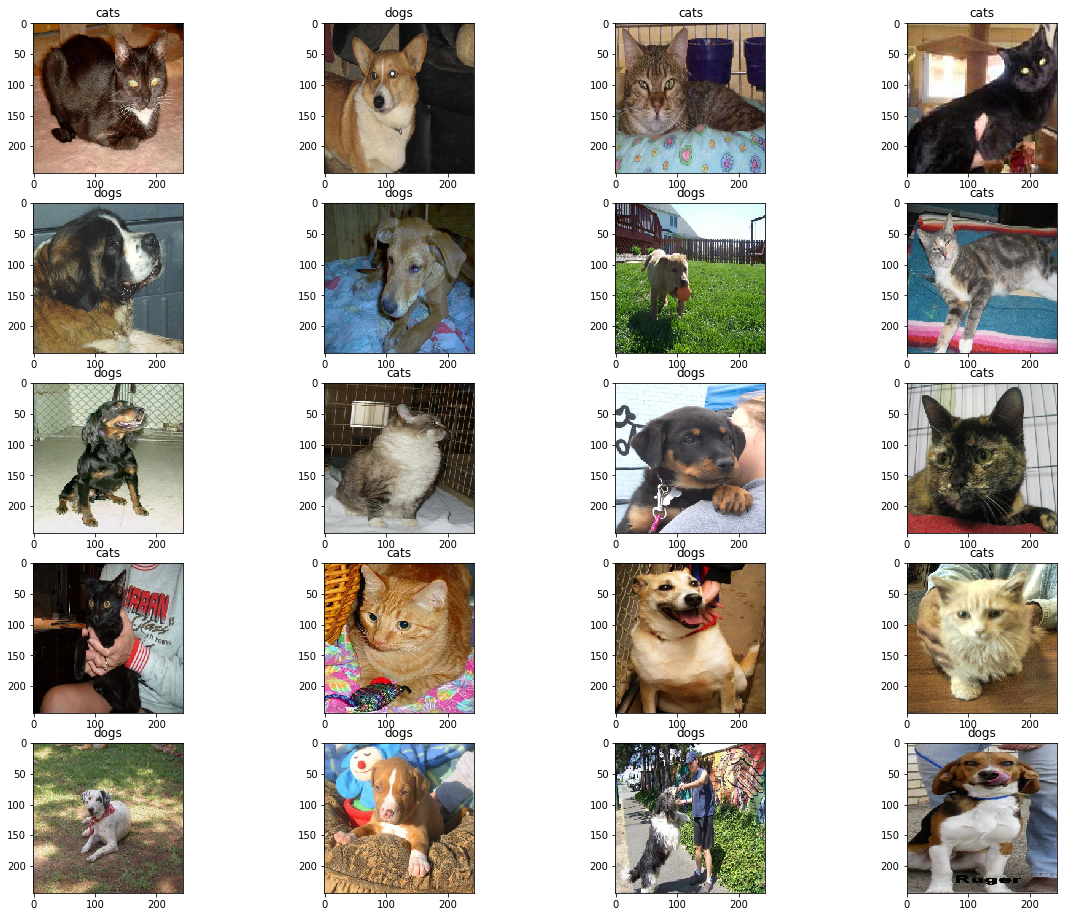

In [4]:
j = np.random.randint(BATCH_SIZE)
X, y = test_set[j]

fig, ax = plt.subplots(5, 4, figsize=(20, 16))

for i, axis in enumerate(ax.flat):
    axis.imshow(X[i])
    cat = classes[int(y[i])]
    axis.set(title=cat)

## Transfer Learning
**Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.**

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.


<br>

Recommended article [A Gentle Introduction to Transfer Learning for Deep Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning)

In [5]:
# load base-model (MobileNet)
mobilenet = MobileNet(input_shape=(244, 244, 3) ,weights='imagenet', include_top=False)

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 1s 0us/step


You can use any pretrained model from keras applications.

In [6]:
# image-input layer
inputs = Input(shape=(IMGSIZE, IMGSIZE, 3))

# define the full network
x = mobilenet(inputs) # base-model
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x) # add dense layers so model learn more complex functions
x = Dropout(0.5)(x) # to avoid overfitting
x = Dense(256, activation='relu')(x) # dense layer 2

# output layer
outputs = Dense(1, activation='sigmoid')(x)

# set the model
model = Model(inputs=inputs, outputs=outputs)

# freeze base-model (mobilenet) weights
model.layers[1].trainable = False

model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

# model summary
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257 

### Traning

In [7]:
history = model.fit_generator(training_set, 
                              epochs=EPOCHS, 
                              validation_data = test_set, 
                             )

Epoch 1/10
251/251 [==============================] - 80s 319ms/step - loss: 0.1556 - accuracy: 0.9395 - val_loss: 0.2357 - val_accuracy: 0.9288
Epoch 2/10
251/251 [==============================] - 40s 160ms/step - loss: 0.0882 - accuracy: 0.9675 - val_loss: 2.0157e-04 - val_accuracy: 0.9659
Epoch 3/10
251/251 [==============================] - 38s 152ms/step - loss: 0.0830 - accuracy: 0.9668 - val_loss: 0.0212 - val_accuracy: 0.9896
Epoch 4/10
251/251 [==============================] - 40s 159ms/step - loss: 0.0897 - accuracy: 0.9658 - val_loss: 9.3523e-05 - val_accuracy: 0.9728
Epoch 5/10
251/251 [==============================] - 40s 159ms/step - loss: 0.0642 - accuracy: 0.9768 - val_loss: 1.3584e-04 - val_accuracy: 0.9763
Epoch 6/10
251/251 [==============================] - 39s 154ms/step - loss: 0.0633 - accuracy: 0.9761 - val_loss: 2.9776e-04 - val_accuracy: 0.9837
Epoch 7/10
251/251 [==============================] - 40s 161ms/step - loss: 0.0675 - accuracy: 0.9734 - val_loss:

## Results

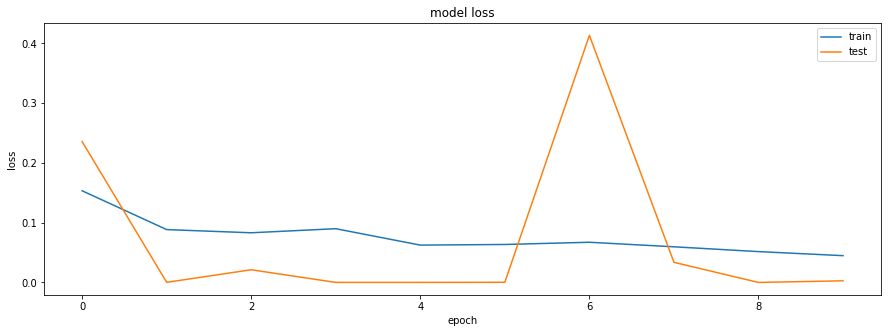

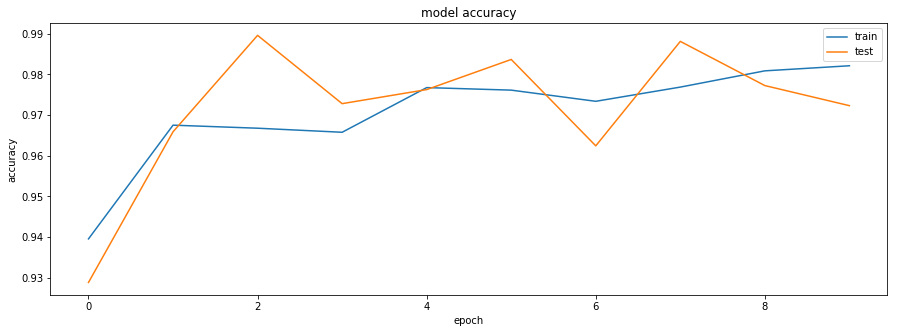

In [8]:
# summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Other Solutions

**Custom CNN Network and Softmax with Keras Solution.**

check out here: **[CNN Dog or Cat Classification](https://www.kaggle.com/code/elcaiseri/keras-cnn-dog-or-cat-classification)**

### If you like, <span style='color:red'>UPVOTE</span> it. feel free to ask me anything in the comment section.